In [1]:
"""
http://sachinashanbhag.blogspot.com/2013/08/block-averaging-estimating-uncertainty_14.html
http://sachinashanbhag.blogspot.com/2013/08/block-averaging-estimating-uncertainty.html
"""
import numpy as np
import pandas as pd

from ase.units import GPa

import scipy.signal as si

In [2]:
df = pd.read_csv('trajectory.csv', index_col='time')

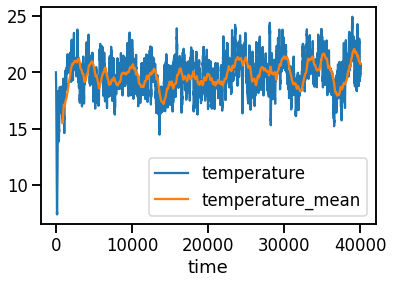

In [3]:
df["temperature_mean"] = df.temperature.rolling(window=200).mean()

df[["temperature", "temperature_mean"]].plot()

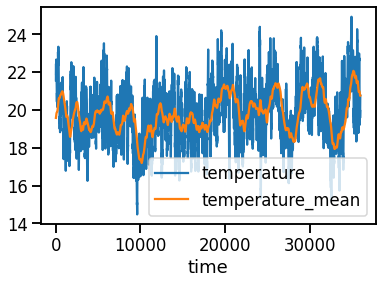

In [4]:
# discard 1000 steps of thermalization
nmin = 1000

df = df.shift(-1000).dropna()
df[['temperature', 'temperature_mean']].plot()

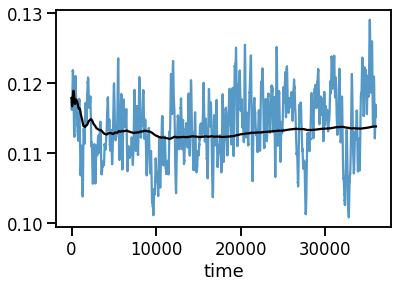

In [5]:
p = df.pressure / GPa

ax = p.plot(alpha=.75)

p.expanding().mean().plot(ax=ax, color='k')

In [6]:
# block average
rows = []

# nn: chunk size
for nn in range(2, 500, 10):

    # number of chunks
    n_chunk = len(p) // nn

    means = []
    for ii in range(n_chunk):
        p_chunk = p.iloc[ii * nn : (ii + 1) * nn]

        means.append(p_chunk.mean())

    std = np.std(means) / (n_chunk - 1) ** 0.5
    mean = np.mean(means)
    row = {"mean": mean, "std": std, "n_chunk": nn}
    rows.append(row)

df_chunks = pd.DataFrame(rows)

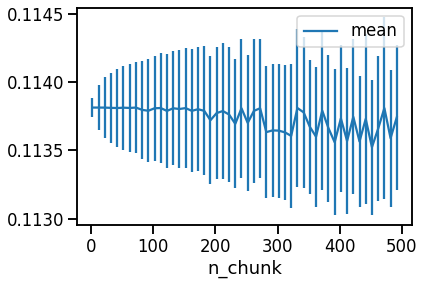

In [7]:
df_chunks.plot(x="n_chunk", y="mean", yerr="std")

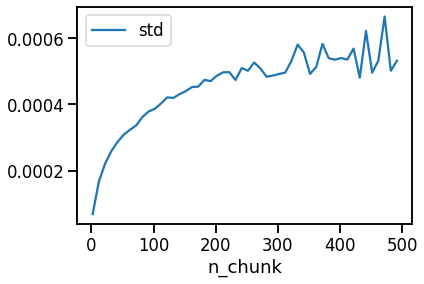

In [8]:
ax = df_chunks.plot(x="n_chunk", y="std")

In [9]:
df_chunks[df_chunks.n_chunk > 250].iloc[0]

mean         0.113702
std          0.000501
n_chunk    252.000000
Name: 25, dtype: float64

266.0

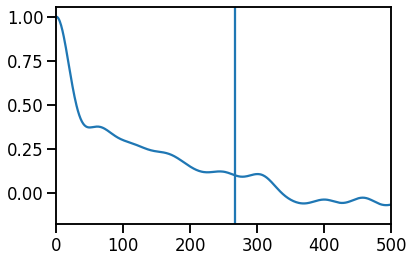

In [10]:
s = p - p.mean()

corr = si.correlate(s, s)[len(s) - 1 :]

corr /= corr[0]

s = pd.Series(corr)
ax = pd.Series(corr).plot()

ax.set_xlim(0, 500)

tau = s.index.where(s < 0.1).min()

ax.axvline(tau)

tau

In [11]:
mean = p.mean()
err = p.std() / (len(p) / tau) ** 0.5

print(f"Mean:  {mean:.5f} +/- {err:.5f} GPa")
print(f"Error: {err / mean * 100:.2f} %")

Mean:  0.11381 +/- 0.00080 GPa
Error: 0.70 %
